In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from math import sin, cos, radians, asin, sqrt
import datetime as dt

%matplotlib inline

C:\Users\eukar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Working with the spray data, assuming the areas that are sprayed with pesticides will have lesser mosquitoes.

In [2]:
# Import spray dataset

spray = pd.read_csv('./data/spray.csv')
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [3]:
# Getting info for the dataset

spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [4]:
# Checking for null value

spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

Although there are 584 missing value for time, will KIV the decision to see if we want to drop this column. Proceed to explore the dataset first.

In [5]:
# Change type for date.

spray['Date'] = pd.to_datetime(spray['Date'])

In [6]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [7]:
# Checking out the entries to ensure there are no duplicates.

duplicates = spray.groupby(['Latitude','Longitude'], as_index=False).count().sort_values('Date', ascending=False)
duplicates.head()

,Latitude,Longitude,Date,Time
11853,41.986460,-87.794225,541,541
11499,41.983917,-87.793088,2,2
0,41.713925,-87.615892,1,1
9533,41.959113,-87.719752,1,1
9522,41.959028,-87.728890,1,1


Seems that there are 2 entries duplicated 541 and 2 times respectively.

In [8]:
duplicates.loc[11499,:]['Longitude']

-87.7930883333333

In [9]:
print('Latitude for 11853: {}'.format(duplicates.loc[11853,:]['Latitude']))
print('Latitude for 11499: {}'.format(duplicates.loc[11499,:]['Latitude']))

Latitude for 11853: 41.98646
Latitude for 11499: 41.9839166666667


In [10]:
# Inspecting the entries for Latitude 41.98646

spray[spray['Latitude'] == 41.98646]

,Date,Time,Latitude,Longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


In [11]:
# Inspecting the entries for Latitude 41.9839166666667

spray[spray['Latitude'] == 41.9839166666667]

,Date,Time,Latitude,Longitude
484,2011-09-07,7:43:40 PM,41.983917,-87.793088
485,2011-09-07,7:43:40 PM,41.983917,-87.793088


Confirmed that the entries are duplicated as the Data and Time are the same across the entries. We will proceed to remove the duplicates from the list.

In [12]:
# Create dup_one for hosting all the duplicates for Latitude 41.98646.

dup_one = (spray['Latitude'] == 41.98646) & (spray['Longitude'] == -87.794225)
spray[dup_one].shape

(541, 4)

In [13]:
# Getting the index for the duplicates, keeping the 1st entry.
# And drop the duplicated entries

spray.drop(spray[dup_one].index[1:], inplace=True)

In [14]:
# Repeat the steps for create dup_two for hosting all the duplicates for Latitude 41.9839166666667.

dup_two = (spray['Latitude'] == 41.9839166666667) & (spray['Longitude'] == -87.7930883333333)
spray[dup_two].shape

(2, 4)

In [15]:
# Getting the index for the duplicates, keeping the 1st entry.
# And drop the duplicated entries

spray.drop(spray[dup_two].index[1:], inplace=True)

In [16]:
# Check to ensure duplicates are dropped.

spray.groupby(['Latitude','Longitude'], as_index=False).count().sort_values('Date', ascending=False).head()

,Latitude,Longitude,Date,Time
0,41.713925,-87.615892,1,1
9534,41.959115,-87.710088,1,1
9523,41.959052,-87.725095,1,1
9524,41.959055,-87.724518,1,1
9525,41.959055,-87.711887,1,1


## EDA for spray dataset

In [17]:
# Import train dataset

train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head(2)

(10506, 12)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [18]:
# Import map

chi_map = np.loadtxt('./data/mapdata_copyright_openstreetmap_contributors.txt')

In [19]:
# Create key data needed for map visualization

traps = train[['Date', 'Trap', 'Longitude','Latitude','WnvPresent']].values
sprays = spray[['Date','Longitude','Latitude']].values

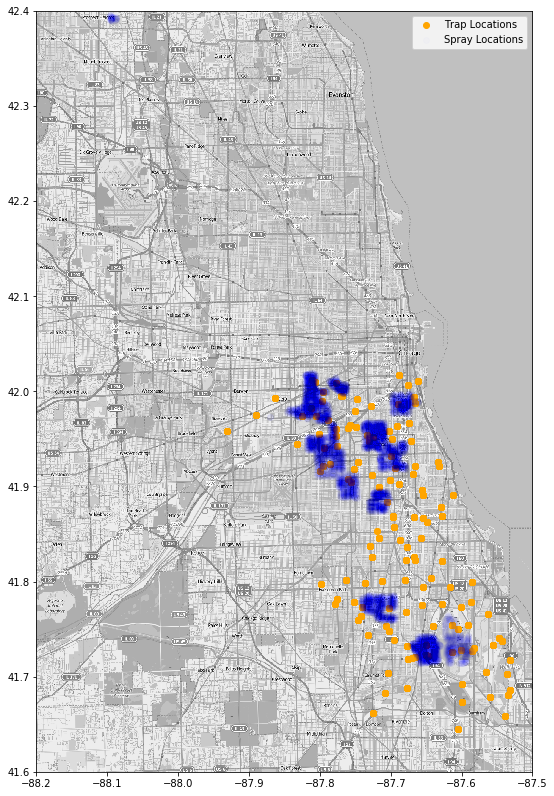

In [20]:
aspect = chi_map.shape[0] / chi_map.shape[1]
lon_lat_box = (-88.2, -87.5, 41.6, 42.4)

plt.figure(figsize=(15,14))
plt.imshow(chi_map, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

plt.scatter(traps[:,2], traps[:,3], marker='o',\
            color='orange', label='Trap Locations')

plt.scatter(sprays[:,1], sprays[:,2], marker='o',\
            color='blue', label='Spray Locations', alpha=.01)

plt.legend();

The map of Chicago all the traps locations (orange) and spray locations (blue). Spotted a spray location at Lat (42.4), Lon(-88.1), as there is no trap in that area, we will put our focus on where the traps are.

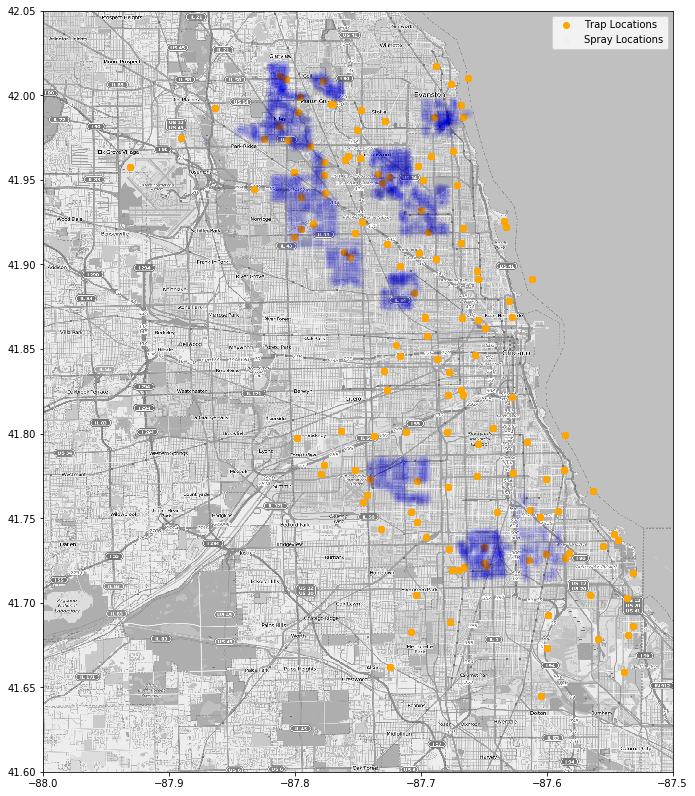

In [21]:
lon_lat_box = (-88, -87.5, 41.6, 42.05)

plt.figure(figsize=(15,14))
plt.imshow(chi_map, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


traps_mask = (traps[:,2] >= lon_lat_box[0])
traps_mask = (traps[:,2] <= lon_lat_box[1]) & traps_mask
traps_mask = (traps[:,3] >= lon_lat_box[2]) & traps_mask
traps_mask = (traps[:,3] <= lon_lat_box[3]) & traps_mask

sprays_mask = (sprays[:,1] >= lon_lat_box[0])
sprays_mask = (sprays[:,1] <= lon_lat_box[1]) & sprays_mask
sprays_mask = (sprays[:,2] >= lon_lat_box[2]) & sprays_mask
sprays_mask = (sprays[:,2] <= lon_lat_box[3]) & sprays_mask

plt.scatter(traps[traps_mask][:,2], traps[traps_mask][:,3], marker='o',\
            color='orange', label='Trap Locations')
plt.scatter(sprays[sprays_mask][:,1], sprays[sprays_mask][:,2], marker='o',\
            color='blue', label='Spray Locations', alpha=.01)

plt.legend();

#### Take a look of the traps and spray locations by Date

In [22]:
spray_dates = list(set(sprays[:,0]))
spray_dates.sort()

spray_by_date = {}

for date in spray_dates:
    spray_mask_tmp = sprays_mask & (sprays[:,0] == date)
    spray_data = sprays[spray_mask_tmp]
    spray_by_date[date] = spray_data

In [23]:
len(spray_dates)

10

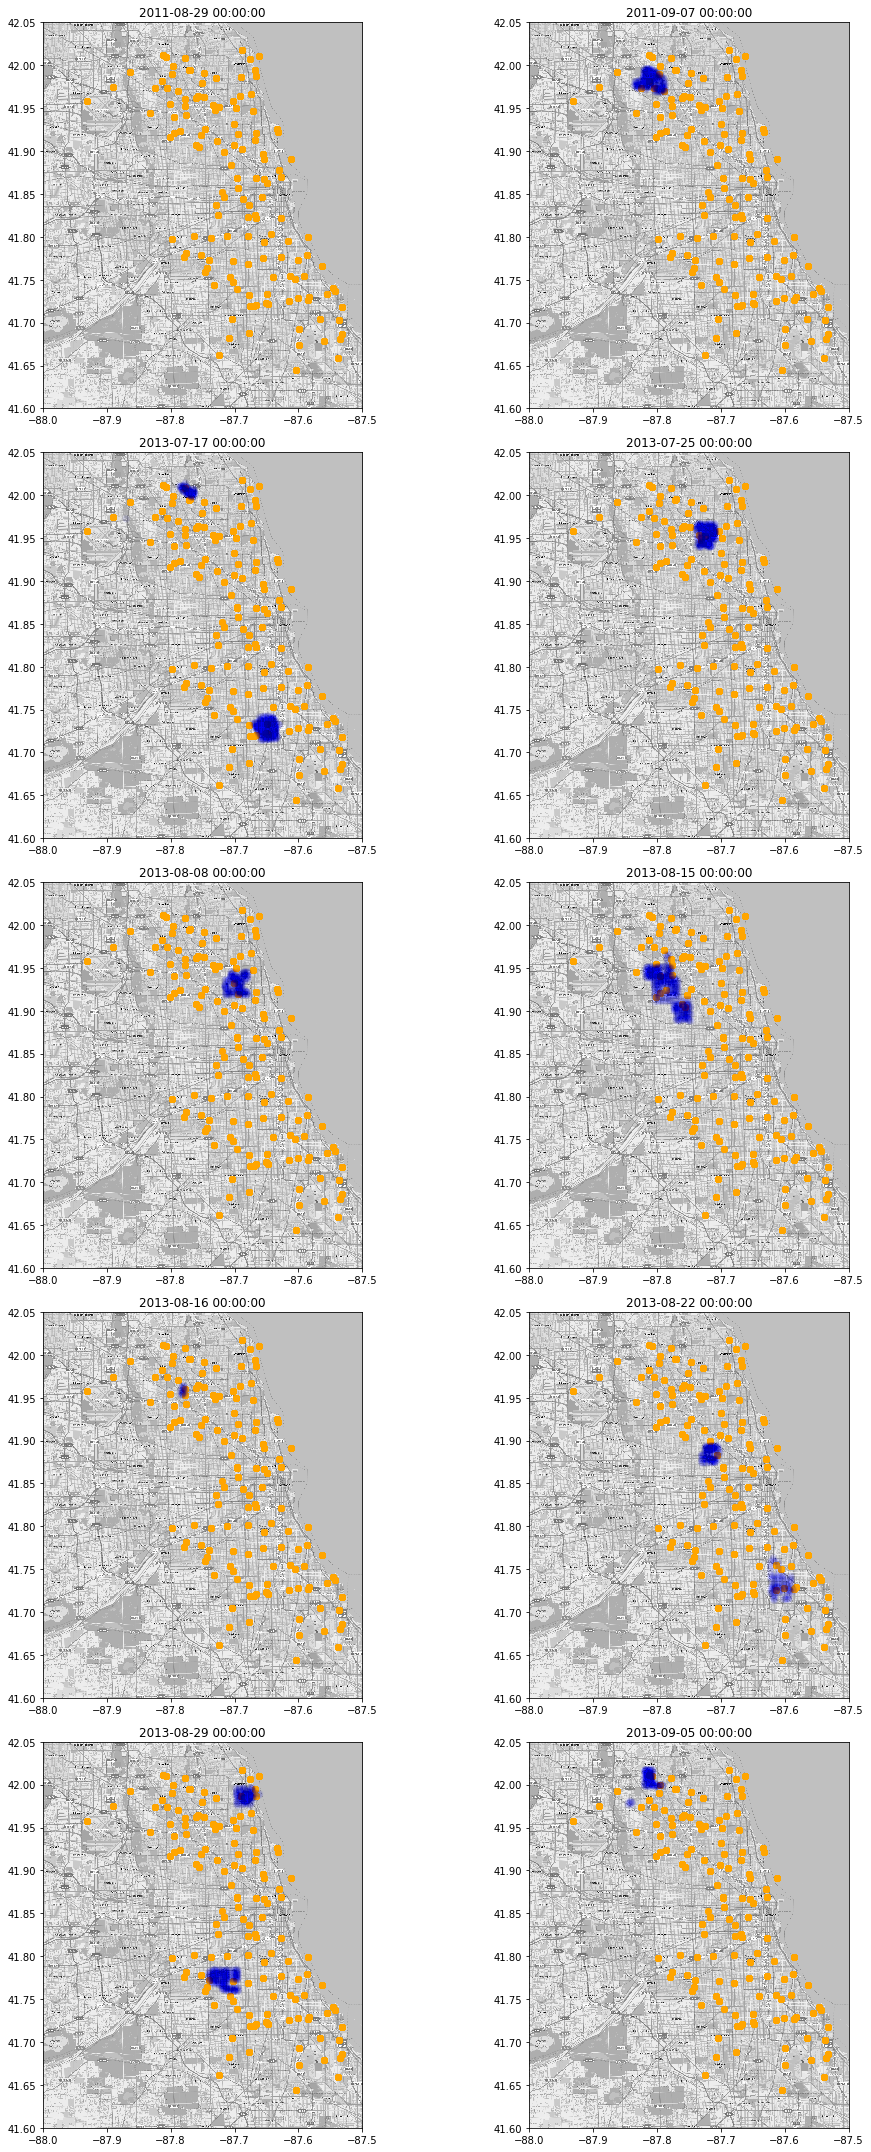

In [24]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))

for date, axis in zip(spray_dates, chain(*ax)):
    axis.imshow(chi_map, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

    spray_tmp = spray_by_date[date]
    
    axis.scatter(traps[traps_mask][:,2], traps[traps_mask][:,3], marker='o',\
                color='orange', label='Trap Locations')
    axis.scatter(spray_tmp[:,1], spray_tmp[:,2], marker='o',\
                color='blue', label='Spray Locations', alpha=.01)
    axis.set_title(date)

plt.tight_layout();

### Summary

Incorporating this data in a classification model will post some challenges.\
Firstly, there is obvious pattern observed with the spraying.\
Secondly, spray data for training dates are only available in 2011 and 2013 and no data for testing dates.